# MExGen for Retrieval Augmented Generation

This notebook walks through an example of using MExGen (Multi-Level Explanations for Generative Language Models) to explain an LLM's response to a question in *retrieval-augmented generation* (RAG). The explanation shows which retrieved documents and which parts thereof are most important to the LLM.

After setting things up in Section 1, we will obtain explanations in the form of document-level attributions to the retrieved documents in Section 2, followed by mixed document- and sentence-level attributions in Section 3. We will then evaluate the fidelity of these explanations to the LLM in Section 4.

## 1. Setup

### Import packages

Standard packages

In [1]:
import json

import matplotlib.pyplot as plt    # for plotting perturbation curves
import numpy as np
from openai import OpenAI    # for VLLM QA model
import pandas as pd    # only for displaying DataFrames
import torch
import transformers
# for HuggingFace QA and retrieval models
from transformers import AutoModelForCausalLM, AutoTokenizer, RagRetriever, RagSequenceForGeneration, T5ForConditionalGeneration, T5TokenizerFast

/u/dwei/icx/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ICX360 classes

In [2]:
from icx360.algorithms.mexgen import CLIME, LSHAP    # explainers
from icx360.metrics import PerturbCurveEvaluator    # fidelity evaluation
from icx360.utils.general_utils import select_device    # set device automatically
from icx360.utils.model_wrappers import HFModel, VLLMModel    # model wrappers

In [3]:
device = select_device()
device

device(type='cuda')

### Load model to explain

Here you can choose from the following models:
- `"flan-t5"`: An older (encoder-decoder) model from HuggingFace
- `"granite-hf"`: A newer (decoder-only) model from HuggingFace
- `"vllm"`: A model served using VLLM. This is a "bring your own model" option, for which you will have to supply the parameters below (`model_name`, `base_url`, `api_key`, and any others).

In [4]:
# model_type = "flan-t5"
model_type = "granite-hf"
# model_type = "vllm"

In [5]:
if model_type == "flan-t5":
    model_name = "google/flan-t5-large"
    model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)
    tokenizer = T5TokenizerFast.from_pretrained(model_name)

elif model_type == "granite-hf":
    model_name = "ibm-granite/granite-3.3-2b-instruct"
    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16).to(device)
    tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

elif model_type == "vllm":
    # IF YOU HAVE A VLLM MODEL, UNCOMMENT AND REPLACE THE FOLLOWING LINES WITH YOUR MODEL'S PARAMETERS
    # base_url = "https://YOUR/MODEL/URL"
    # api_key = YOUR_API_KEY
    # openai_kwargs = {}
    model = OpenAI(api_key=api_key, base_url=base_url, **openai_kwargs)
    # Corresponding HuggingFace tokenizer for applying chat template
    # model_name = "YOUR/MODEL-NAME"
    # tokenizer_kwargs = {}
    tokenizer = AutoTokenizer.from_pretrained(model_name, **tokenizer_kwargs)

else:
    raise ValueError("Unknown model type")

Loading checkpoint shards: 100%|██████████████████████████████████████| 2/2 [00:07<00:00,  3.79s/it]


We then wrap the model with a common API (`HFModel` or `VLLMModel`) that the explainer will use.

In [6]:
if model_type in ("flan-t5", "granite-hf"):
    wrapped_model = HFModel(model, tokenizer)
elif model_type == "vllm":
    wrapped_model = VLLMModel(model, model_name, tokenizer)

### Define question

We wil consider the following question from the user:

In [7]:
question = "What is the coldest state of the contiguous USA?"

### Option 1: Load documents from file

For convenience, documents related to this question have already been retrieved and saved to a file, which you can just load.

In [8]:
with open("RAG_retrieved_docs.json", "r") as f:
    documents = json.load(f)

### Option 2: Retrieve documents using a retrieval model

Alternatively, if you would like to retrieve documents for a different question or just make things "more real," you can load a retrieval model and retrieve documents from its associated dataset.

In [9]:
import logging
import warnings
warnings.filterwarnings("ignore")
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)
transformers.logging.set_verbosity_error()

We instantiate a retriever, an encoding model for the retriever, and the corresponding tokenizer. 

For the retriever, you may first have to install the `faiss-cpu` package, if it was not installed together with `icx360`. If so, uncomment and run the first cell below.

In [10]:
# !uv pip install faiss-cpu

In [11]:
retriever = RagRetriever.from_pretrained("facebook/rag-sequence-nq", index_name="exact", use_dummy_dataset=True, append_question=False, trust_remote_code=True)
retriever_model = RagSequenceForGeneration.from_pretrained("facebook/rag-sequence-nq", use_dummy_dataset=True)
retriever_tokenizer = AutoTokenizer.from_pretrained("facebook/rag-sequence-nq")

The following function retrieves documents relevant to a question:

In [12]:
def retrieve_documents(question, n_docs = 5):
    """
    Retrieve relevant documents for a given question using a RAG retriever.

    Args:
        question (str): The input question to retrieve documents for
        n_docs (int): Number of documents to retrieve

    Returns:
        list: List of decoded document contents
    """

    # Encoding question
    inputs = retriever_tokenizer(question, return_tensors="pt")
    input_ids = inputs["input_ids"]
    question_hidden_states = retriever_model.question_encoder(input_ids)[0]

    # Retrieving documents that are related to the question
    docs_dict = retriever(input_ids.numpy(),
                          question_hidden_states.detach().numpy(),
                          n_docs = n_docs,
                          return_tensors="pt")

    documents = retriever_tokenizer.batch_decode(docs_dict["context_input_ids"], skip_special_tokens = True)

    return [doc.split('//')[0] for doc in documents]

Call the function:

In [13]:
documents = retrieve_documents(question)

### Show question and documents

In either case, let's review the question and  retrieved documents.

In [14]:
print(f"Question: ''{question}'' \n")

for idx, doc in enumerate(documents):
    print(f"Document {idx}: {doc} \n")

Question: ''What is the coldest state of the contiguous USA?'' 

Document 0:  Alaska / Alaska Alaska (; ; ; ) is a U.S. state in the northwest extremity of North America. The Canadian administrative divisions of British Columbia and Yukon border the state to the east, its most extreme western part is Attu Island, and it has a maritime border with Russia (Chukotka Autonomous Okrug) to the west across the Bering Strait. To the north are the Chukchi and Beaufort seas—the southern parts of the Arctic Ocean. The Pacific Ocean lies to the south and southwest. It is the largest state in the United States by area and the seventh largest subnational division in  

Document 1:  Alaska / the 90s °F (the low-to-mid 30s °C), while in the winter, the temperature can fall below . Precipitation is sparse in the Interior, often less than a year, but what precipitation falls in the winter tends to stay the entire winter. The highest and lowest recorded temperatures in Alaska are both in the Interior. Th

Note that all of the documents are about Alaska, which is actually not in the contiguous USA. It might be that the retriever paid attention to "coldest" but not "contiguous" in the question.

### Generate model response (with and without retrieved documents)

As a check on our setup, we will have the model answer the question, via the `wrapped_model` object created above, and both with and without the retrieved documents.

First, we define functions to put the question and retrieved documents into a prompt template.

In [15]:
def create_template_for_flant5_generation(documents, question):

    system_template = "Answer the user Question using the following Context: \n\n"

    templated_system_prompt = system_template

    DOCUMENTS_template = "Context:\n\n"
    QUESTION_template = "\n\nQuestion: "

    templated = [templated_system_prompt + DOCUMENTS_template]
    documents = [doc + "\n\n" for doc in documents]

    templated.extend(documents)
    templated.append(QUESTION_template + question)

    unit_types = ["n"] + len(documents) * ["p"] + ["n"]

    return templated, unit_types

def create_template_for_granite_generation(documents, question):


    DOCUMENTS_template = "Documents: \n"
    QUESTION_template = "\n\nQuestion: "

    templated = [DOCUMENTS_template]
    documents = [f"Document {idx}: {doc} \n" for idx, doc in enumerate(documents)]

    templated.extend(documents)
    templated.append(QUESTION_template + question)

    unit_types = ["n"] + len(documents) * ["p"] + ["n"]

    return templated, unit_types

Selecting the prompt template corresponding to the model:

In [16]:
if model_type == "flan-t5":
    apply_template_for_generation = create_template_for_flant5_generation
else:
    apply_template_for_generation = create_template_for_granite_generation

Next, we specify parameters for model generation, as a dictionary `model_params`. These parameters include `max_new_tokens`/`max_tokens`, whether to use the model's chat template, and any instruction provided as a system prompt.

In [17]:
model_params = {}
if model_type == "vllm":
    model_params["max_tokens"] = 64
    model_params["seed"] = 20250430
else:
    model_params["max_new_tokens"] = 64
    
if model_type in ("granite-hf", "vllm"):
    model_params["chat_template"] = True
    model_params["system_prompt"] = ("You are an AI assistant that provides a *very short* answer to the user *solely based on the "
        "provided documents*, aiming to answer the user as correctly as possible. If no documents are provided, answer from your memory.")

model_params

{'max_new_tokens': 64,
 'chat_template': True,
 'system_prompt': 'You are an AI assistant that provides a *very short* answer to the user *solely based on the provided documents*, aiming to answer the user as correctly as possible. If no documents are provided, answer from your memory.'}

Now we generate a response, first **without** the retrieved documents:

> Note that the model may answer with a state that is in the contiguous USA (your results may vary).

In [18]:
wrapped_model.generate("".join(apply_template_for_generation([], question)[0]), **model_params)

[' The coldest state in the contiguous USA is Alaska.']

**With** the retrieved documents:
> Note that the model answers incorrectly! As mentioned, Alaska is not in the contiguous USA.

In [19]:
prompt, unit_types = apply_template_for_generation(documents, question)
wrapped_model.generate("".join(prompt), **model_params)

[' Alaska is the coldest state of the contiguous USA.']

## 2. Document-Level Explanation

### Instantiate explainer

Here you can choose between two attribution algorithms used by MExGen, C-LIME and L-SHAP. These are more efficient variants of LIME and SHAP respectively. In either case, the explanation takes the form of importance scores assigned to parts of the retrieved documents, and these scores are computed by calling the LLM on perturbed versions of the input prompt.

In [20]:
explainer_alg = "clime"
# explainer_alg = "lshap"

if explainer_alg == "clime":
    explainer_class = CLIME
elif explainer_alg == "lshap":
    explainer_class = LSHAP

We instantiate the explainer with a "scalarizer", which quantifies the effect that perturbed inputs have on the output of the model compared to its response to the original input. Here we use the `"prob"` scalarizer, which computes the probability of generating the original response conditioned on perturbed inputs.

In [21]:
explainer = explainer_class(wrapped_model, scalarizer="prob")

### Call explainer

We call the explainer's `explain_instance` method with the following parameters:
- `prompt`: This is a list of 7 prompt elements ("units"), returned by `apply_template_for_generation`. The first unit is part of the prompt template (the word "Context:" or "Documents:", and possibly an instruction), the middle 5 units are the retrieved documents, and the last unit is the question.
- `unit_types`: Also a list of length 7, returned by `apply_template_for_generation`. The type corresponding to the documents is `"p"` ("paragraph"), and the type of the first and last units is `"n"` ("not of interest"). The explainer will thus attribute only to the documents.
- `ind_segment`: Also a list of 7 elements, all equal to `False`. This means that units will not be segmented into smaller units (for now) and an importance score will be computed for each document as a whole.
- `model_params`: The desired model generation parameters from above

In [22]:
ind_segment = [False] * len(prompt)

In [23]:
output_dict_doc = explainer.explain_instance(prompt, unit_types, ind_segment=ind_segment, model_params=model_params)

toma_get_probs batch size = 16


### Look at output

The explainer returns a dictionary. The `"output_orig"` item shows the response for the original input.

In [24]:
output_dict_doc["output_orig"].output_text

[' Alaska is the coldest state of the contiguous USA.']

The `"attributions"` item is itself a dictionary, containing the 7 prompt units (`"units"`), the corresponding `"unit_types"`, and the importance scores, computed according to the `"prob"` scalarizer and non-zero only for the units of interest (the documents). These are displayed below as a pandas DataFrame.

In [25]:
pd.DataFrame(output_dict_doc["attributions"]).set_index("units")[["unit_types", "prob"]]

,unit_types,prob
units,,
Documents: \n,n,-0.000000
"Document 0: Alaska / Alaska Alaska (; ; ; ) is a U.S. state in the northwest extremity of North America. The Canadian administrative divisions of British Columbia and Yukon border the state to the east, its most extreme western part is Attu Island, and it has a maritime border with Russia (Chukotka Autonomous Okrug) to the west across the Bering Strait. To the north are the Chukchi and Beaufort seas—the southern parts of the Arctic Ocean. The Pacific Ocean lies to the south and southwest. It is the largest state in the United States by area and the seventh largest subnational division in \n",p,0.478495
"Document 1: Alaska / the 90s °F (the low-to-mid 30s °C), while in the winter, the temperature can fall below . Precipitation is sparse in the Interior, often less than a year, but what precipitation falls in the winter tends to stay the entire winter. The highest and lowest recorded temperatures in Alaska are both in the Interior. The highest is in Fort Yukon (which is just inside the arctic circle) on June 27, 1915, making Alaska tied with Hawaii as the state with the lowest high temperature in the United States. The lowest official Alaska temperature is in Prospect Creek on January 23, \n",p,0.409607
"Document 2: Alaska / Southeast Alaska is a mid-latitude oceanic climate (Köppen climate classification: ""Cfb"") in the southern sections and a subarctic oceanic climate (Köppen ""Cfc"") in the northern parts. On an annual basis, Southeast is both the wettest and warmest part of Alaska with milder temperatures in the winter and high precipitation throughout the year. Juneau averages over of precipitation a year, and Ketchikan averages over . This is also the only region in Alaska in which the average daytime high temperature is above freezing during the winter months. The climate of Anchorage and south central Alaska is mild by Alaskan standards due \n",p,0.472641
"Document 3: Alaska / the action of the sea is directed"". Alaska is the northernmost and westernmost state in the United States and has the most easterly longitude in the United States because the Aleutian Islands extend into the Eastern Hemisphere. Alaska is the only non-contiguous U.S. state on continental North America; about of British Columbia (Canada) separates Alaska from Washington. It is technically part of the continental U.S., but is sometimes not included in colloquial use; Alaska is not part of the contiguous U.S., often called ""the Lower 48"". The capital city, Juneau, is situated on the mainland of the North American continent \n",p,0.428662
"Document 4: Alaska / but is not connected by road to the rest of the North American highway system. The state is bordered by Yukon and British Columbia in Canada, to the east, the Gulf of Alaska and the Pacific Ocean to the south and southwest, the Bering Sea, Bering Strait, and Chukchi Sea to the west and the Arctic Ocean to the north. Alaska's territorial waters touch Russia's territorial waters in the Bering Strait, as the Russian Big Diomede Island and Alaskan Little Diomede Island are only apart. Alaska has a longer coastline than all the other U.S. states combined. Alaska is the \n",p,0.344068
\n\nQuestion: What is the coldest state of the contiguous USA?,n,-0.000000


## 3. Mixed Document- and Sentence-Level Explanation

We will now consider the multi-level aspect of MExGen by obtaining mixed document- and sentence-level attributions to the retrieved documents.

### Set up parameters

For this illustration, we will segment the two most important documents (as determined in the previous section) into sentences. (The number of top documents can be changed.)

In [26]:
num_top_units = 2

The parameters for `explain_instance()` will be as follows:
- `units` and `unit_types`: Take existing document-level units and unit types from `output_dict_doc["attributions"]`
- `ind_segment`: We create a Boolean array that has value `True` in the positions corresponding to the top documents and `False` otherwise. This will tell the explainer to segment only the top documents.
- `segment_type = "s"` for segmentation into sentences
- `model_params` as before

In [27]:
units = output_dict_doc["attributions"]["units"]
unit_types = output_dict_doc["attributions"]["unit_types"]
segment_type = "s"

ind_segment = np.zeros_like(output_dict_doc["attributions"]["prob"], dtype=bool)
ind_segment[np.argsort(output_dict_doc["attributions"]["prob"])[-num_top_units:]] = True
ind_segment

array([False,  True, False,  True, False, False, False])

### Call Explainer

Now we call `explain_instance()` with the above parameters

In [28]:
output_dict_mixed = explainer.explain_instance(units, unit_types, ind_segment=ind_segment, segment_type=segment_type, model_params=model_params)

toma_get_probs batch size = 92
toma_get_probs batch size = 64
toma_get_probs batch size = 28


### Look at output

Mixed document- and sentence-level importance scores according to the `"prob"` scalarizer:

In [29]:
pd.DataFrame(output_dict_mixed["attributions"]).set_index("units")[["unit_types", "prob"]]

,unit_types,prob
units,,
Documents: \n,n,-0.000000
Document 0: Alaska / Alaska Alaska (; ; ; ) is a U.S. state in the northwest extremity of North America.,s,0.468246
"The Canadian administrative divisions of British Columbia and Yukon border the state to the east, its most extreme western part is Attu Island, and it has a maritime border with Russia (Chukotka Autonomous Okrug) to the west across the Bering Strait.",s,0.311257
To the north are the Chukchi and Beaufort seas—the southern parts of the Arctic Ocean.,s,0.183641
The Pacific Ocean lies to the south and southwest.,s,0.149030
It is the largest state in the United States by area and the seventh largest subnational division in \n,s,0.142128
"Document 1: Alaska / the 90s °F (the low-to-mid 30s °C), while in the winter, the temperature can fall below . Precipitation is sparse in the Interior, often less than a year, but what precipitation falls in the winter tends to stay the entire winter. The highest and lowest recorded temperatures in Alaska are both in the Interior. The highest is in Fort Yukon (which is just inside the arctic circle) on June 27, 1915, making Alaska tied with Hawaii as the state with the lowest high temperature in the United States. The lowest official Alaska temperature is in Prospect Creek on January 23, \n",p,0.655111
"Document 2: Alaska / Southeast Alaska is a mid-latitude oceanic climate (Köppen climate classification: ""Cfb"") in the southern sections and a subarctic oceanic climate (Köppen ""Cfc"") in the northern parts.",s,0.270497
"On an annual basis, Southeast is both the wettest and warmest part of Alaska with milder temperatures in the winter and high precipitation throughout the year.",s,0.376434


## 4. Evaluate fidelity of attributions to explained model

We now evaluate the fidelity of both the document-level and mixed-level explanations to the behavior of the LLM. We do this by computing *perturbation curves*. Given a set of attribution scores, the perturbation curve measures how much the LLM's response changes as we remove more and more units from the input, in decreasing order of importance according to the scores.

### Instantiate perturbation curve evaluator

We instantiate a `PerturbCurveEvaluator` to compute perturbation curves. Similar to the explainer, `PerturbCurveEvaluator` requires a scalarizer to quantify how much the response changes from the original response as more input units are removed. Here we use the same `"prob"` scalarizer as the explainer.

In [30]:
evaluator = PerturbCurveEvaluator(wrapped_model, scalarizer="prob")

### Evaluate perturbation curves

We call the `eval_perturb_curve` method to compute perturbation curves for both document-level and mixed-level attribution scores. Parameters for `eval_perturb_curve` are as follows:
- `output_dict_doc` or `output_dict_mixed`: The dictionary returned by the explainer
- `"prob"`: The score label in `output_dict["attributions"]`
- `token_frac=True`: This setting allows comparison between different kinds of units (documents vs. mixed) because it takes into account the number of tokens in each unit, which is considered as the length of the unit and in ranking units.
- `model_params`: The same model generation parameters as before

Document-level:

In [31]:
perturb_curve_doc = evaluator.eval_perturb_curve(output_dict_doc, "prob", token_frac=True, model_params=model_params)
perturb_curve_doc = pd.DataFrame(perturb_curve_doc).set_index("frac")

toma_get_probs batch size = 4


Mixed-level:

In [32]:
perturb_curve_mixed = evaluator.eval_perturb_curve(output_dict_mixed, "prob", token_frac=True, model_params=model_params)
perturb_curve_mixed = pd.DataFrame(perturb_curve_mixed).set_index("frac")

toma_get_probs batch size = 11


### Plot perturbation curves

The perturbation curves are plotted below as a function of the fraction of tokens removed from the input. The y-axis is the decrease in the log probability of generating the original response, computed by the scalarizer of `PerturbCurveEvaluator`.

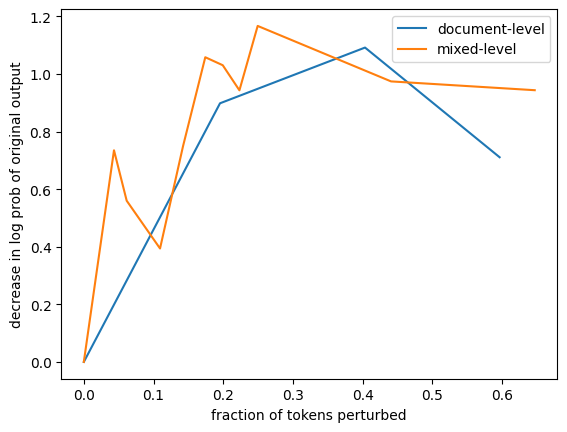

In [33]:
plt.plot(perturb_curve_doc.loc[0] - perturb_curve_doc, label="document-level")
plt.plot(perturb_curve_mixed.loc[0] - perturb_curve_mixed, label="mixed-level")

plt.xlabel("fraction of tokens perturbed")
plt.ylabel("decrease in log prob of original output")
plt.legend()

In general, we are looking for perturbation curves to increase as more tokens are removed from the input. A higher perturbation curve is better because it indicates that the units identified by the explanation as important actually do have a larger effect on the LLM's output, and hence the explanation is more faithful to the LLM. Your results may vary however.